In [282]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from itertools import cycle
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
%matplotlib inline 

# 1. Preparing Data

### Loading HH Data

In [283]:
hh_village_coord_fcs = pd.read_csv("../Data/Intermediate_files/hh_village_coord_fcs.csv")

In [284]:
hh_data_2011_cluster_minHH = pd.read_csv("../Data/Intermediate_files/hh_data_2011_cluster_minHH.csv")

### Loading CNN features

In [285]:
#google_sat_CNN_features = pd.read_csv("../Data/Intermediate_files/google_sat_CNN_features.csv")

In [286]:
#google_sat_CNN_features_lsms = pd.read_csv("../Data/Intermediate_files/google_sat_CNN_features_lsms.csv")

In [287]:
#google_sat_CNN_features_lsms_VGG16_block4_pool = pd.read_csv("../Data/Intermediate_files/google_sat_CNN_features_lsms_VGG16_block4_pool.csv")

In [288]:
#google_sat_CNN_features_lsms_VGGF_caffe_conv7_mean = pd.read_csv("../Data/Intermediate_files/google_sat_CNN_features_lsms_VGGF_caffe_conv7_mean.csv")

In [289]:
google_sat_CNN_features_lsms_VGGF_caffe_conv7_mean_100imagescluster = pd.read_csv("../Data/Intermediate_files/google_sat_CNN_features_lsms_VGGF_caffe_conv7_mean_100imagescluster.csv")

### Merging

In [290]:
data=hh_data_2011_cluster_minHH.merge(google_sat_CNN_features_lsms_VGGF_caffe_conv7_mean_100imagescluster,on=["i","j"])

In [291]:
start_features=len(hh_data_2011_cluster_minHH.columns)+2

In [292]:
data_features=data.iloc[:,start_features:]

### Defining predictors and predicting variables

In [293]:
y = data["cons"] #Average normalized consumption per cluster
y = y[y > 0]
y = np.log(y) #Log-normal distribution

In [294]:
y2 = data["poor_majority"] #Dummy variable for majority of poor in the cluster

In [295]:
X=data_features

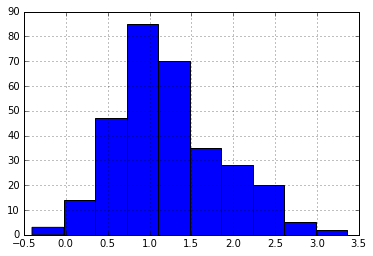

In [296]:
y.hist()

In [297]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0.291924,0.068823,0.017631,0.248543,0.326709,0.050860,0.399913,0.020031,0.143854,0.012067,...,0.041486,0.632786,0.000037,0.879723,0.170953,0.401817,0.048103,0.081173,0.164577,0.051656
1,0.262870,0.081398,0.012684,0.190422,0.308329,0.045846,0.331663,0.030801,0.122497,0.010185,...,0.050007,0.488522,0.000000,0.736051,0.185541,0.344004,0.043975,0.075466,0.133451,0.061188
2,0.332226,0.036973,0.013022,0.205900,0.384501,0.059003,0.392832,0.010993,0.104263,0.005208,...,0.025200,0.578562,0.000531,0.981637,0.163697,0.418472,0.059499,0.083191,0.170706,0.047975
3,0.344775,0.073419,0.021959,0.243460,0.371201,0.037094,0.451379,0.014772,0.199083,0.005553,...,0.049265,0.718210,0.000000,0.970162,0.161915,0.483167,0.047791,0.133360,0.243238,0.015733
4,0.317799,0.047743,0.022632,0.213685,0.363133,0.032384,0.424504,0.011410,0.121238,0.031045,...,0.032528,0.576067,0.003322,0.923956,0.152044,0.379146,0.060154,0.106679,0.149290,0.046884


# 2. Predicting Continuous Indicator

## From PCA Components

In [298]:
alpha=1.0 # Choosing the regularization parameter by hand
clf = Ridge(alpha)

In [299]:
pca = PCA(n_components=10)

In [300]:
pca.fit(data_features.transpose())

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [301]:
eigenvectors=pca.components_

In [302]:
X2 = pd.DataFrame(np.transpose(eigenvectors))
X2.shape

(309, 10)

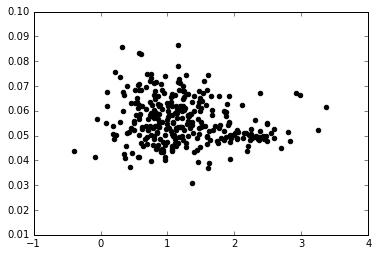

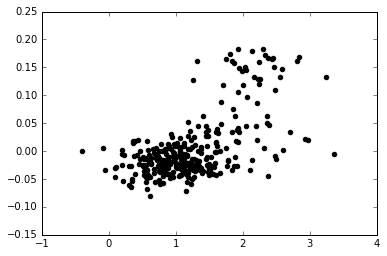

In [303]:
for i in range(2):
    plt.figure()
    plt.scatter(y, eigenvectors[i],  color='black')

In [304]:
r2 = cross_val_score(clf, X2, y, cv=10,scoring='r2')
print("R2: %0.2f (+/- %0.2f)" % (r2.mean(), r2.std() * 2)) 

R2: -0.10 (+/- 0.34)


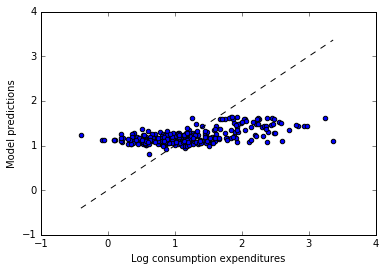

In [305]:
y_hat = cross_val_predict(clf, X2, y, cv=10)
fig, ax = plt.subplots()
ax.scatter(y, y_hat, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
ax.set_xlabel('Log consumption expenditures')
ax.set_ylabel('Model predictions')
plt.show()

## From all (4096) features

In [306]:
alpha=4.0 # Choosing the regularization parameter by hand
clf = Ridge(alpha)

In [307]:
r2 = cross_val_score(clf, X, y, cv=10,scoring='r2')
print("R2: %0.2f (+/- %0.2f)" % (r2.mean(), r2.std() * 2)) 

R2: 0.05 (+/- 0.46)


In [308]:
neg_mean_squared_error = cross_val_score(clf, X, y, cv=10,scoring='neg_mean_squared_error')
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (neg_mean_squared_error.mean(), neg_mean_squared_error.std() * 2)) 

neg_mean_squared_error: -0.25 (+/- 0.10)


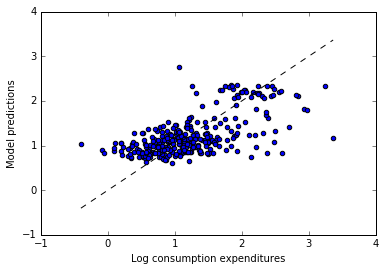

In [309]:
y_hat = cross_val_predict(clf, X, y, cv=10)
fig, ax = plt.subplots()
ax.scatter(y, y_hat, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
ax.set_xlabel('Log consumption expenditures')
ax.set_ylabel('Model predictions')
plt.show()

# 3. Predicting Dummy Indicator from all features

In [310]:
model = linear_model.LogisticRegression(penalty="l2")
model.fit(X, y2) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [311]:
accuracy = cross_val_score(model, X, y2, cv=10)
f1 = cross_val_score(model, X, y2, cv=10,scoring='f1')
precision = cross_val_score(model, X, y2, cv=10,scoring='precision')
recall= cross_val_score(model, X, y2, cv=10,scoring='recall')
auc= cross_val_score(model, X, y2, cv=10,scoring='roc_auc')
confusion= cross_val_score(model, X, y2, cv=10,scoring='roc_auc')

In [312]:
scores = cross_val_score(model, X, y2, cv=10,scoring='precision')
accuracy_print=("Accuracy: %0.2f (+/- %0.2f)" % (accuracy.mean(), accuracy.std() * 2))
f1_print=("F1: %0.2f (+/- %0.2f)" % (f1.mean(), f1.std() * 2))
precision_print=("Precision: %0.2f (+/- %0.2f)" % (precision.mean(), precision.std() * 2))
recall_print=("Recall: %0.2f (+/- %0.2f)" % (recall.mean(), recall.std() * 2))
auc_print=("AUC: %0.2f (+/- %0.2f)" % (auc.mean(), auc.std() * 2))
print(os.linesep.join([accuracy_print,f1_print,precision_print,recall_print,auc_print]))

Accuracy: 0.74 (+/- 0.15)
F1: 0.35 (+/- 0.47)
Precision: 0.54 (+/- 0.75)
Recall: 0.33 (+/- 0.51)
AUC: 0.75 (+/- 0.29)
